In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
path = os.path.join('.', 'airsim_rec.txt')
samples = pd.read_csv(path, sep='\t')
samples.head()

,VehicleName,TimeStamp,POS_X,POS_Y,POS_Z,Q_W,Q_X,Q_Y,Q_Z,Throttle,Steering,Brake,Gear,Handbrake,RPM,Speed,ImageFile
0,PhysXCar,1647112984530,-126.317,-111.717,-0.583506,0.730287,0.000023,0.00002,0.68314,0.5,0.0,1.0,1,0,1111.23,1.914880e-07,img_PhysXCar__0_1647112984529910600.png
1,PhysXCar,1647112984625,-126.317,-111.717,-0.584261,0.730287,0.000023,0.00002,0.68314,0.5,0.0,1.0,1,0,1108.52,-5.885740e-09,img_PhysXCar__0_1647112984624649200.png
2,PhysXCar,1647112984723,-126.317,-111.717,-0.583726,0.730287,0.000023,0.00002,0.68314,0.5,0.0,1.0,1,0,1110.74,-2.283870e-07,img_PhysXCar__0_1647112984722277700.png
3,PhysXCar,1647112984821,-126.317,-111.717,-0.584295,0.730287,0.000023,0.00002,0.68314,0.5,0.0,1.0,1,0,1109.47,-2.594750e-07,img_PhysXCar__0_1647112984820508800.png
4,PhysXCar,1647112984915,-126.317,-111.717,-0.584701,0.730287,0.000023,0.00002,0.68314,0.5,0.0,1.0,1,0,1105.99,5.037620e-08,img_PhysXCar__0_1647112984915058800.png


In [ ]:
# df = samples[['POS_X', 'POS_Y', 'Speed']][:700]
# df.to_csv('./r1.csv', index=False)

In [ ]:
N = 10
Xs = samples["POS_X"].to_numpy()
Ys = samples["POS_Y"].to_numpy()
# Zs = samples["POS_Z"].to_numpy()
Xs = np.append(Xs, np.repeat(Xs[-1], N))
Ys = np.append(Ys, np.repeat(Ys[-1], N))
speeds = samples['Speed'].to_numpy()
route = np.vstack((Xs,Ys)).T

In [ ]:
N = 10
Xs = samples["POS_X"].to_numpy() + 1
Ys = samples["POS_Y"].to_numpy() + 1
# Zs = samples["POS_Z"].to_numpy()
Xs = np.append(Xs, np.repeat(Xs[-1], N))
Ys = np.append(Ys, np.repeat(Ys[-1], N))
np.random.seed(0)
indx = np.sort(np.random.choice(700, 100))
car_position = np.vstack((Xs,Ys)).T[indx]
QWs = samples["Q_W"].to_numpy()[indx]
QXs = samples["Q_X"].to_numpy()[indx]
QYs = samples["Q_Y"].to_numpy()[indx]
QZs = samples["Q_Z"].to_numpy()[indx]

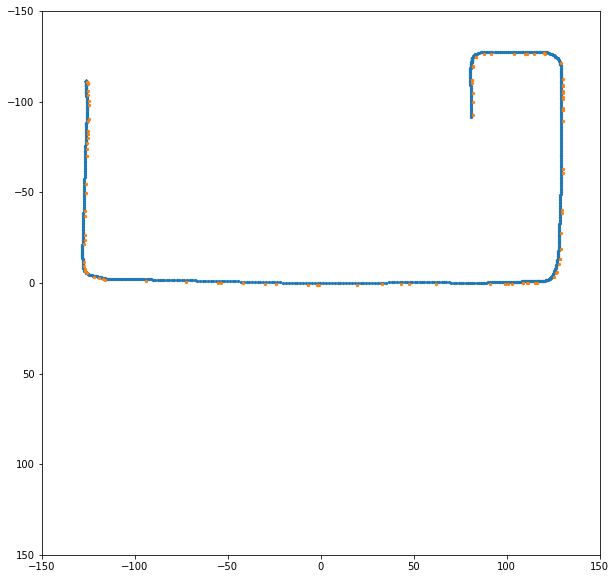

In [ ]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
ax.scatter(route[:700,0], route[:700,1], s=5)
ax.scatter(car_position[:700,0], car_position[:700,1], s=5)
ax.set_xlim(-150, 150)
ax.set_ylim(150, -150)
plt.show()

In [ ]:
def nearest(point, set_of_points):
    diff = np.square(set_of_points - point)
    diff = diff.sum(axis=1)
    return np.argmin(diff)

In [ ]:
range = 50
idx = 0
idx_arr = []
for pt in car_position:
    idx_ = nearest(pt, route[idx:idx+range])
    idx = idx_ + idx
    idx_arr.append(idx)

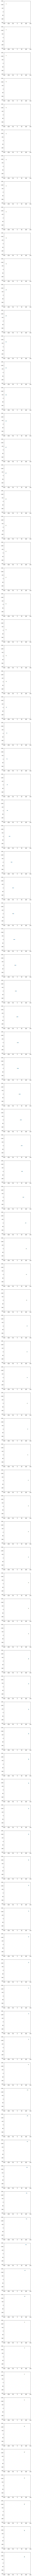

In [ ]:
l = len(car_position)

fig, axes = plt.subplots(l, 1, figsize=(5, l * 5))
for i, ax in enumerate(axes):
    start = idx_arr[i]
    ax.scatter(route[start:start+N+1,0], route[start:start+N+1,1], s=5)
    ax.scatter(car_position[i,0], car_position[i,1], s=5)
    ax.set_xlim(-150, 150)
    ax.set_ylim(150, -150)

In [ ]:
def find_route_index(pt, route, idx, range=50):
    idx_ = nearest(pt, route[idx:idx+range])
    idx = idx_ + idx
    return idx

In [ ]:
def convergent_points(pt, selcted_route):
    l = len(selcted_route)
    v = pt - selcted_route[0]
    r = np.linspace((1,1), (0,0), l)
    v = r * v
    s = selcted_route + v
    return s

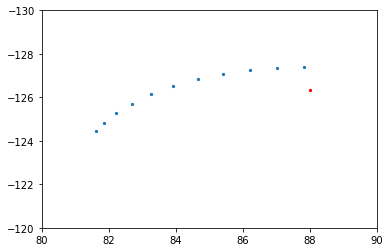

In [ ]:
l = len(car_position)

idx = 620
pt = car_position[-11]
idx_route = find_route_index(pt, route, idx)
selected_route = route[idx_route:idx_route+11]

##################
plt.scatter(selected_route[:,0], selected_route[:,1], s=5)
plt.scatter(pt[0], pt[1], s=5, color='r')
plt.xlim(80, 90)
plt.ylim(-120, -130)
plt.show()

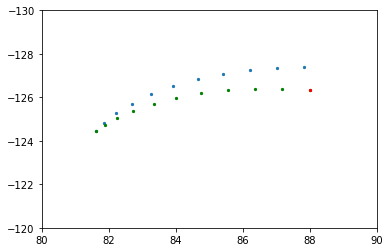

In [ ]:
l = len(car_position)

idx = 620
pt = car_position[-11]
conv_pts = convergent_points(pt, selected_route)

##################
plt.scatter(selected_route[:,0], selected_route[:,1], s=5)
plt.scatter(conv_pts[:,0], conv_pts[:,1], s=5, color='g')
plt.scatter(pt[0], pt[1], s=5, color='r')
plt.xlim(80, 90)
plt.ylim(-120, -130)
plt.show()

In [ ]:
def quaternion_to_euler(q_x, q_y, q_z, q_w):
        # t0 = +2.0 * (q_w * q_x + q_y * q_z)
        # t1 = +1.0 - 2.0 * (q_x * q_x + q_y * q_y)
        # roll_x = np.arctan2(t0, t1)
     
        # t2 = +2.0 * (q_w * q_y - q_z * q_x)
        # np.clip(t2, -1.0, +1.0)
        # pitch_y = np.arcsin(t2)
     
        t3 = +2.0 * (q_w * q_z + q_x * q_y)
        t4 = +1.0 - 2.0 * (q_y * q_y + q_z * q_z)
        yaw_z = np.arctan2(t3, t4)
     
        return None, None, yaw_z

In [ ]:
def normalize_points(set_of_points, speeds, z_rotate):
    s = set_of_points - set_of_points[0]
    diffs = s[1:] - s[:-1]
    norm_speed = (speeds[1:] + speeds[:-1])/2
    norm_diffs = diffs / np.expand_dims(norm_speed, axis=-1)
    s = np.cumsum(norm_diffs, axis=0)
    R = np.array([[np.cos(z_rotate), -np.sin(z_rotate)],
                  [np.sin(z_rotate), np.cos(z_rotate)]])
    s = s @ R    
    return s

In [ ]:
N = 10
idx = 620
pt = car_position[-11]
idx_route = find_route_index(pt, route, idx)
selected_route = route[idx_route:idx_route+N+1]
conv_pts = convergent_points(pt, selected_route)

In [ ]:
len(speeds)

1163

In [ ]:
QWs = samples["Q_W"].to_numpy()[indx][-11]
QXs = samples["Q_X"].to_numpy()[indx][-11]
QYs = samples["Q_Y"].to_numpy()[indx][-11]
QZs = samples["Q_Z"].to_numpy()[indx][-11]
_, _, yaw = quaternion_to_euler(QXs, QYs, QZs, QWs)
s = normalize_points(conv_pts, speeds[idx_route:idx_route+N+1], yaw)

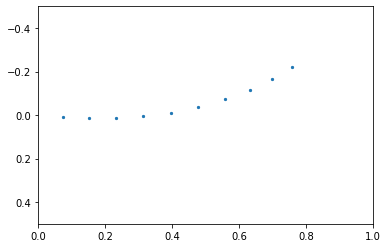

In [ ]:
plt.scatter(s[:,0], s[:,1], s=5)
plt.ylim(0.5, -0.5)
plt.xlim(0, 1)
plt.show()